In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
BASE_PATH = "/kaggle/input/c2ty2bcoulouredspurious/colored_mnist/type2_background"
EASY_PATH = os.path.join(BASE_PATH, "easy_train")
HARD_PATH = os.path.join(BASE_PATH, "hard_test")


In [3]:
transform = transforms.ToTensor()


In [4]:
easy_full = datasets.ImageFolder(EASY_PATH, transform=transform)
hard_test = datasets.ImageFolder(HARD_PATH, transform=transform)

print("Easy full size:", len(easy_full))
print("Hard test size:", len(hard_test))


Easy full size: 60000
Hard test size: 10000


In [5]:
EASY_FRACTION = 0.25

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

def stratified_subset(dataset, fraction, seed=42):
    targets = np.array(dataset.targets)
    indices = np.arange(len(targets))

    splitter = StratifiedShuffleSplit(
        n_splits=1,
        test_size=fraction,
        random_state=seed
    )

    _, subset_indices = next(splitter.split(indices, targets))
    return Subset(dataset, subset_indices)


In [7]:

easy_subset = stratified_subset(easy_full, EASY_FRACTION)

hard_subset = stratified_subset(hard_test, EASY_FRACTION)

print("Easy subset size:", len(easy_subset))
print("Hard subset size:", len(hard_subset))


Easy subset size: 15000
Hard subset size: 2500


In [8]:
targets = np.array([easy_full.targets[i] for i in easy_subset.indices])
indices = np.arange(len(targets))

splitter = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)

train_idx, val_idx = next(splitter.split(indices, targets))

easy_train = Subset(easy_subset, train_idx)
easy_val   = Subset(easy_subset, val_idx)

print("Easy Train size:", len(easy_train))
print("Easy Val size:", len(easy_val))


Easy Train size: 12000
Easy Val size: 3000


In [9]:
def count_classes(dataset):
    counts = {i: 0 for i in range(10)}
    for _, y in dataset:
        counts[y] += 1
    return counts


In [10]:
print(" Easy Train counts:", count_classes(easy_train))
print(" Easy Val counts  :", count_classes(easy_val))
print(" Hard Test counts :", count_classes(hard_subset))


 Easy Train counts: {0: 1185, 1: 1349, 2: 1191, 3: 1226, 4: 1169, 5: 1084, 6: 1183, 7: 1253, 8: 1170, 9: 1190}
 Easy Val counts  : {0: 296, 1: 337, 2: 298, 3: 307, 4: 292, 5: 271, 6: 296, 7: 313, 8: 293, 9: 297}
 Hard Test counts : {0: 245, 1: 284, 2: 258, 3: 253, 4: 245, 5: 223, 6: 240, 7: 257, 8: 243, 9: 252}


In [11]:
BATCH_SIZE = 64

train_loader = DataLoader(
    easy_train, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    easy_val, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)

hard_loader = DataLoader(
    hard_subset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)


In [12]:
class LazyCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3,6, kernel_size=9, stride=2, padding=4)   # 28 → 14
        self.conv2 = nn.Conv2d(6, 8, kernel_size=7, stride=2, padding=3)   # 14 → 7
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)  # 7 → 7

        self.fc = nn.Linear(16 * 7 * 7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        return self.fc(x)


In [13]:
model = LazyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


In [14]:
EPOCHS = 15

for epoch in range(EPOCHS):
    model.train()
    correct, total, loss_sum = 0, 0, 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    train_acc = 100 * correct / total
    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {loss_sum/len(train_loader):.4f} | "
        f"Easy Train Acc: {train_acc:.2f}%"
    )


Epoch 01 | Train Loss: 2.1744 | Easy Train Acc: 15.52%
Epoch 02 | Train Loss: 1.0904 | Easy Train Acc: 66.16%
Epoch 03 | Train Loss: 0.5174 | Easy Train Acc: 92.78%
Epoch 04 | Train Loss: 0.3801 | Easy Train Acc: 94.57%
Epoch 05 | Train Loss: 0.3410 | Easy Train Acc: 94.73%
Epoch 06 | Train Loss: 0.3224 | Easy Train Acc: 94.79%
Epoch 07 | Train Loss: 0.3116 | Easy Train Acc: 94.92%
Epoch 08 | Train Loss: 0.3023 | Easy Train Acc: 94.97%
Epoch 09 | Train Loss: 0.2923 | Easy Train Acc: 94.97%
Epoch 10 | Train Loss: 0.2848 | Easy Train Acc: 95.02%
Epoch 11 | Train Loss: 0.2755 | Easy Train Acc: 95.01%
Epoch 12 | Train Loss: 0.2691 | Easy Train Acc: 95.03%
Epoch 13 | Train Loss: 0.2578 | Easy Train Acc: 95.05%
Epoch 14 | Train Loss: 0.2514 | Easy Train Acc: 95.09%
Epoch 15 | Train Loss: 0.2421 | Easy Train Acc: 95.15%


In [15]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

easy_val_acc = 100 * correct / total
print(f" Easy Validation Accuracy: {easy_val_acc:.2f}%")


 Easy Validation Accuracy: 95.13%


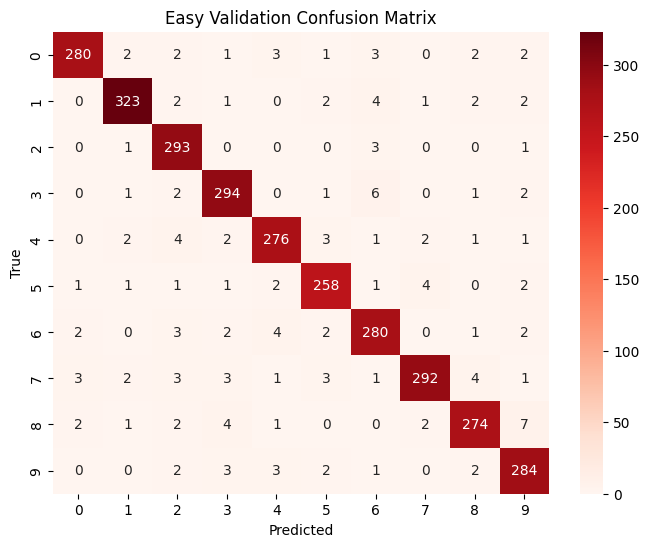

In [16]:
# collect predictions for Easy Validation set
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = outputs.argmax(1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Easy Validation Confusion Matrix")
plt.show()


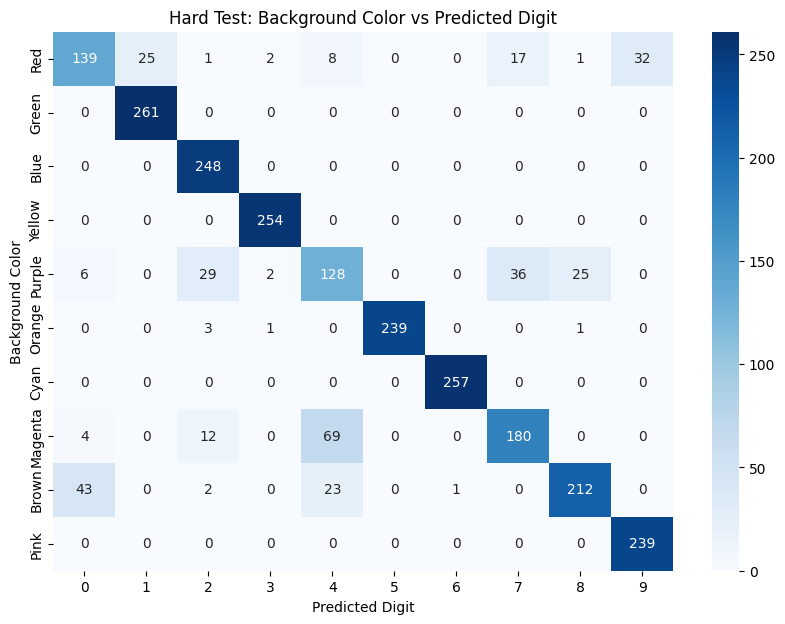

In [17]:
# Color reference (digit → RGB + name)
DIGIT_TO_COLOR = {
    0: (np.array([255,   0,   0]), "Red"),
    1: (np.array([  0, 255,   0]), "Green"),
    2: (np.array([  0,   0, 255]), "Blue"),
    3: (np.array([255, 255,   0]), "Yellow"),
    4: (np.array([128,   0, 128]), "Purple"),
    5: (np.array([255, 165,   0]), "Orange"),
    6: (np.array([  0, 255, 255]), "Cyan"),
    7: (np.array([255,   0, 255]), "Magenta"),
    8: (np.array([165,  42,  42]), "Brown"),
    9: (np.array([255, 192, 203]), "Pink")
}

# helper: nearest color by L2 distance
def nearest_color(mean_rgb):
    dists = {
        k: np.linalg.norm(mean_rgb - v[0])
        for k, v in DIGIT_TO_COLOR.items()
    }
    return min(dists, key=dists.get)

# matrix: rows = color, cols = predicted digit
color_pred_matrix = np.zeros((10, 10), dtype=int)

model.eval()
with torch.no_grad():
    for imgs, _ in hard_loader:
        imgs = imgs.to(device)
        preds = model(imgs).argmax(1).cpu().numpy()

        imgs_np = imgs.cpu().numpy().transpose(0, 2, 3, 1) * 255

        for i in range(len(preds)):
            mean_rgb = imgs_np[i].mean(axis=(0, 1))
            color_digit = nearest_color(mean_rgb.astype(int))
            color_pred_matrix[color_digit, preds[i]] += 1

# labels
color_names = [DIGIT_TO_COLOR[i][1] for i in range(10)]
digit_labels = [str(i) for i in range(10)]

# plot
plt.figure(figsize=(10, 7))
sns.heatmap(
    color_pred_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=digit_labels,
    yticklabels=color_names
)
plt.xlabel("Predicted Digit")
plt.ylabel("Background Color")
plt.title("Hard Test: Background Color vs Predicted Digit")
plt.show()


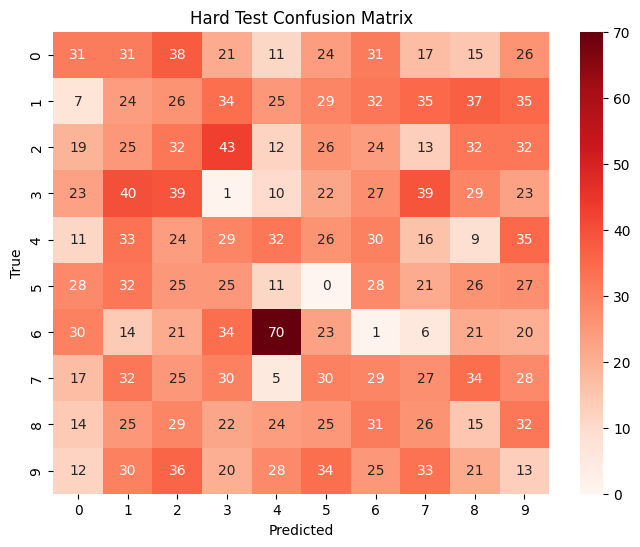

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Collect predictions
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for imgs, labels in hard_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=range(10),
    yticklabels=range(10)
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Hard Test Confusion Matrix")
plt.show()


In [22]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in hard_loader:
        x = x.to(device)
        y = y.to(device)

        preds = model(x).argmax(1)
        y_true.extend(y.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())

hard_acc = 100 * np.mean(np.array(y_true) == np.array(y_pred))
print(f"Hard Test Accuracy: {hard_acc:.2f}%")

Hard Test Accuracy: 7.04%


In [ ]:
# Safety import (in case kernel was reset)
from PIL import Image

base_dir = "/kaggle/input/c2ty2bcoulouredspurious/colored_mnist/type2_background/hard_test/1"
img_files = sorted(os.listdir(base_dir))

found = False
model.eval()

with torch.no_grad():
    for img_name in img_files:
        img_path = os.path.join(base_dir, img_name)

        img = Image.open(img_path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)

        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred_class = int(np.argmax(probs))
        confidence = probs[pred_class] * 100

        # LOOK FOR COLOR FAILURE: true = 1, predicted = 0
        if pred_class == 0:
            found = True

            print("===== COLOR BIAS PROOF FOUND =====")
            print("Image File          :", img_name)
            print("True Label          : 1")
            print("Background Color    : RED")
            print("Model Prediction    : 0")
            print(f"Prediction Confidence: {confidence:.2f}%")

            plt.figure(figsize=(6,4))
            plt.imshow(img)
            plt.axis("off")
            plt.title(
                f"RED DIGIT 1\nMODEL PREDICTION = 0\n"
                f"CONFIDENCE = {confidence:.2f}%",
                fontsize=14,
                color="darkred"
            )
            plt.show()
            break

if not found:
    print(" No RED digit '1' was predicted as '0' by the model.")
    print("This indicates the model relies more on shape than color for digit '1'.")


In [ ]:
MODEL_PATH = "/kaggle/working/task1final_colored_mnist_cnn.pth"

torch.save(model.state_dict(), MODEL_PATH)

print(" Task-1 model saved successfully!")
print(" Path:", MODEL_PATH)
